In [1]:
pip install albumentations

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import albumentations as A # library for data augmenations
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
import os

C:\Users\Kirill\AppData\Local\Programs\Python\Python311\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Uploading of three different datasets and their processing through preprocessing

Agriadapt (ag) dataset

In [3]:
tags = ['valid', 'train', 'test']
ag_images = []
ag_labels = []
with ZipFile('Agriadapt_archive.zip', 'r') as archive:
  files = archive.namelist()
  for i in tags:
    # images
    images = [f for f in files if '/' + i + '/images' in f]

    for file in images:
      if file.lower().endswith(('.jpg')):
        ag_images.append(file)

    # labels
    labels = [f for f in files if '/' + i + '/labels' in f]
    for file in labels:
      if file.lower().endswith(('.txt')):
          ag_labels.append(file)

  for img_file in ag_images:
    archive.extract(img_file, 'ag_images')

  for lbl_file in ag_labels:
    archive.extract(lbl_file, 'ag_labels')

Chicory crop (ch) dataset

In [4]:
tags = ['train', 'test']
ch_images = []
ch_labels = []
with ZipFile('Chicory crop_archive.zip', 'r') as archive:
  files = archive.namelist()
  for i in tags:
    # images
    images = [f for f in files if '/' + i + '/images' in f]

    for file in images:
      if file.lower().endswith(('.jpg')):
        ch_images.append(file)

    # labels
    labels = [f for f in files if '/' + i + '/labels' in f]
    for file in labels:
      if file.lower().endswith(('.txt')):
          ch_labels.append(file)

  for img_file in ch_images:
    archive.extract(img_file, 'ch_images')

  for lbl_file in ch_labels:
    archive.extract(lbl_file, 'ch_labels')

Tobacco (to) dataset

In [5]:
to_images = []
to_labels = []
with ZipFile('Tobacco_archive.zip', 'r') as archive:
  files = archive.namelist()
  # images
  images = [f for f in files if '/data' in f]

  for file in images:
    if file.lower().endswith(('.png')):
      to_images.append(file)

  # labels
  labels = [f for f in files if '/maskref' in f]

  for file1 in labels:
    if file1.lower().endswith(('.png')):
      to_labels.append(file1)

  for img_file in to_images:
    archive.extract(img_file, 'to_images')

  for lbl_file in to_labels:
    archive.extract(lbl_file, 'to_labels')

In [6]:
ag_images = ag_images[:50]
ch_images = ch_images[:250]
to_images = to_images[:300]

ag_labels = ag_labels[:50]
ch_labels = ch_labels[:250]
to_labels = to_labels[:300]

Creation of polygon coordinates for Tobacco dataset

In [7]:
to_polygon_masks = [] # polygon annotations for each image
for i in range(len(to_images)):
  img_path = os.path.join('to_images', to_images[i])
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  mask_path = os.path.join('to_labels', to_labels[i])
  mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

  contours, _ = cv2.findContours(
    (mask == 255).astype(np.uint8),
    cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)

  polygons = []

  for cnt in contours:
    epsilon = 0.001 * cv2.arcLength(cnt, True)
    polygon = cv2.approxPolyDP(cnt, epsilon, True)
    polygons.append(polygon)

  to_polygon_masks.append(polygons)

In [8]:
len(to_images)

300

Checking sizes of images

In [9]:
a =  os.path.join('ag_images', ag_images[0])
a = cv2.imread(a)
b = os.path.join('ch_images', ch_images[0])
b = cv2.imread(b)
c = os.path.join('to_images', to_images[0])
c = cv2.imread(c)
a.shape, b.shape, c.shape

((1280, 1280, 3), (416, 416, 3), (352, 480, 3))

As every datset contatins images of different sizes, it's necessary to transform them into one size, whick i took to be equal to 512 by 512 pixels, including masks

In [10]:
# Agriadapt dataset
from pathlib import Path

resized_ag_images = []
resized_ag_labels = []

transform = A.Compose(
    [A.Resize(height=512, width=512, interpolation=cv2.INTER_LINEAR)],
    bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])
)

for i in range(len(ag_images)):
  img_path = os.path.join('ag_images', ag_images[i])
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  txt_path = os.path.join('ag_labels', ag_labels[i])
  with open(txt_path) as f:
    lines = [list(map(float, line.strip().split())) for line in f]

  bboxes = []
  class_labels = []
  for line in lines:
    if int(line[0]) == 1:
      class_labels.append(int(line[0]))
      x_center, y_center, width, height = line[1], line[2], line[3], line[4]
      x_min = max(0, x_center - width/2)
      y_min = max(0, y_center - height/2)
      x_max = min(1, x_center + width/2)
      y_max = min(1, y_center + height/2)

      # Return valid YOLO format (recalculated to ensure consistency)
      new_width = x_max - x_min
      new_height = y_max - y_min
      new_x_center = x_min + new_width/2
      new_y_center = y_min + new_height/2
      bboxes.append([new_x_center, new_y_center, new_width, new_height])

  transformed = transform(image=img, bboxes=bboxes, class_labels=class_labels)
  resized_ag_images.append(transformed['image'])

  labels = []
  for class_id, bbox in zip(transformed['class_labels'], transformed['bboxes']):
    labels.append([bbox[0], bbox[1], bbox[2], bbox[3]])

  resized_ag_labels.append(labels)

In [11]:
# Chicory crop dataset
resized_ch_images = []
resized_ch_labels = []

transform = A.Compose(
    [A.Resize(height=512, width=512, interpolation=cv2.INTER_LINEAR)],
    bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])
)

for i in range(len(ch_images)):
  img_path = os.path.join('ch_images', ch_images[i])
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  txt_path = os.path.join('ch_labels', ch_labels[i])
  with open(txt_path) as f:
    lines = [list(map(float, line.strip().split())) for line in f]

  bboxes = []
  class_labels = []
  for line in lines:
    if int(line[0]) == 0:
      class_labels.append(int(line[0]))
      x_center, y_center, width, height = line[1], line[2], line[3], line[4]
      x_min = max(0, x_center - width/2)
      y_min = max(0, y_center - height/2)
      x_max = min(1, x_center + width/2)
      y_max = min(1, y_center + height/2)

      # Return valid YOLO format (recalculated to ensure consistency)
      new_width = x_max - x_min
      new_height = y_max - y_min
      new_x_center = x_min + new_width/2
      new_y_center = y_min + new_height/2
      bboxes.append([new_x_center, new_y_center, new_width, new_height])

  transformed = transform(image=img, bboxes=bboxes, class_labels=class_labels)
  resized_ch_images.append(transformed['image'])

  labels = []
  for class_id, bbox in zip(transformed['class_labels'], transformed['bboxes']):
    labels.append([bbox[0], bbox[1], bbox[2], bbox[3]])

  resized_ch_labels.append(labels)

In [12]:
# Tobacco dataset
resized_to_images = []
resized_to_labels = []

transform = A.Compose(
    [A.Resize(height=512, width=512, interpolation=cv2.INTER_LINEAR)])

for i in range(len(to_images)):
  img_path = os.path.join('to_images', to_images[i])
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  mask_path = os.path.join('to_labels', to_labels[i])
  mask_ = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

  transformed = transform(image=img, mask = mask_)
  # transformed1 = transform(image=mask)

  resized_to_images.append(transformed['image'])
  resized_to_labels.append(transformed['mask'])

In [13]:
np.unique(resized_to_labels[0])

array([  0, 255], dtype=uint8)

In [14]:
i

299

In [15]:
resized_to_labels[0]

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255]], dtype=uint8)

In [16]:
new_to_polygon_masks = [] # polygon annotations for each image
for i in range(len(to_images)):
  mask = resized_to_labels[i].copy()

  contours, _ = cv2.findContours(
    (mask == 255).astype(np.uint8),
    cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)

  polygons = []

  for cnt in contours:
    epsilon = 0.001 * cv2.arcLength(cnt, True)
    polygon = cv2.approxPolyDP(cnt, epsilon, True)
    polygons.append(polygon)

  new_to_polygon_masks.append(polygons)

Depiction of one image from each dataset

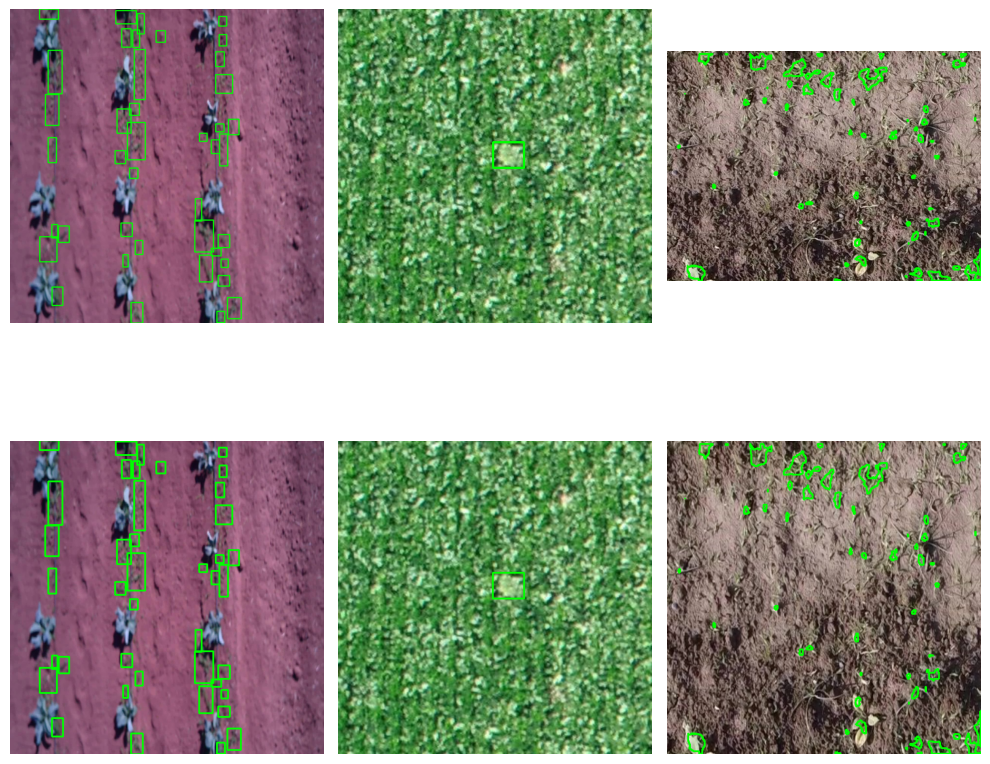

In [17]:
# Resized images (512 by 512)
fig, axs = plt.subplots(2, 3, figsize=(10, 10))

## - - -Upper row - - -
# Agriadapt
img_path = os.path.join('ag_images', ag_images[0])
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

txt_path = os.path.join('ag_labels', ag_labels[0])
with open(txt_path) as f:
  lines = [list(map(float, line.strip().split())) for line in f]

for i in lines:
  if int(i[0]) == 1:
    x = i[1] - i[3]/2
    y = i[2] - i[4]/2
    x1 = i[1] + i[3]/2
    y1 = i[2] + i[4]/2

    x, y, x1, y1 = int(x*1280), int(y*1280), int(x1*1280), int(y1*1280)
    cv2.rectangle(img, (x, y), (x1, y1), color=(0, 255, 0), thickness=4)

axs[0, 0].imshow(img)
axs[0, 0].axis('off')

# Chicory crop
img_path = os.path.join('ch_images', ch_images[0])
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

txt_path = os.path.join('ch_labels', ch_labels[0])
with open(txt_path) as f:
  lines = [list(map(float, line.strip().split())) for line in f]

for i in lines:
  if int(i[0]) == 0:
    x = i[1] - i[3]/2
    y = i[2] - i[4]/2
    x1 = i[1] + i[3]/2
    y1 = i[2] + i[4]/2

    x, y, x1, y1 = int(x*416), int(y*416), int(x1*416), int(y1*416)
    cv2.rectangle(img, (x, y), (x1, y1), color=(0, 255, 0), thickness=2)

axs[0, 1].imshow(img)
axs[0, 1].axis('off')

# Tobacco dataset
img_path = os.path.join('to_images', to_images[0])
# print(img_path)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for i in to_polygon_masks[0]:
  cv2.drawContours(img, [i], -1, (0,255,0), 2)

axs[0, 2].imshow(img)
axs[0, 2].axis('off')

# - - -Lower row - - -
# Agriadapt
img = resized_ag_images[0].copy()
for i in resized_ag_labels[0]:
  x = i[0] - i[2]/2
  y = i[1] - i[3]/2
  x1 = i[0] + i[2]/2
  y1 = i[1] + i[3]/2

  x, y, x1, y1 = int(x*512), int(y*512), int(x1*512), int(y1*512)
  cv2.rectangle(img, (x, y), (x1, y1), color=(0, 255, 0), thickness=2)

axs[1, 0].imshow(img)
axs[1, 0].axis('off')

# Chicory crop
img1 = resized_ch_images[0].copy()
for i in resized_ch_labels[0]:
  x = i[0] - i[2]/2
  y = i[1] - i[3]/2
  x1 = i[0] + i[2]/2
  y1 = i[1] + i[3]/2

  x, y, x1, y1 = int(x*512), int(y*512), int(x1*512), int(y1*512)
  cv2.rectangle(img1, (x, y), (x1, y1), color=(0, 255, 0), thickness=2)

axs[1, 1].imshow(img1)
axs[1, 1].axis('off')

# Tobacco dataset
img1 = resized_to_images[0].copy()

for i in new_to_polygon_masks[0]:
  cv2.drawContours(img1, [i], -1, (0,255,0), 2)

axs[1, 2].imshow(img1)
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

## Data augmentation

In [18]:
# resized_ch_images = resized_ch_images[:600]
# resized_to_images = resized_to_images[:600]

# resized_ch_labels = resized_ch_labels[:600]
# resized_to_labels = resized_to_labels[:600]

Weather simulation together with scaling, rotation, flipping

In [19]:
# - - -Light Haze/Fog
def seed_number(seed_num, if_Chicory):
  random.seed(seed_num)
  np.random.seed(seed_num)

  scale_r = (0.5, 1)
  if if_Chicory == True:
    scale_r = (1, 1.65)
  alpha = random.uniform(0.05, 0.25)
  brightness_coef = random.uniform(0.75, 0.9)
  saturation_coef = random.uniform(0.75, 0.9)
  contrast_coef = random.uniform(0.7, 0.9)

  transform = A.Compose([
      A.Affine(scale=scale_r, rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.RandomFog(fog_coef_range=(0.15, 0.35), alpha_coef=alpha, p=1),
      A.ColorJitter(brightness=brightness_coef, saturation=saturation_coef, contrast=contrast_coef, hue = 0, p=1)],
      bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']), seed = seed_num)
  return transform

agiadapt_img_1 = []
agiadapt_lbl_1 = []
chicory_img_1 = []
chicory_lbl_1 =[]

for i in range(len(resized_ag_images)):
  loc_img = []
  loc_lbl = []
  for s in [135]:
    transform = seed_number(s + i, False)
    transform_1 = transform(image = resized_ag_images[i], bboxes=resized_ag_labels[i], class_labels = [1 for l in range(len(resized_ag_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  agiadapt_img_1.append(loc_img)
  agiadapt_lbl_1.append(loc_lbl)

for i in range(len(resized_ch_images)//6):
  loc_img = []
  loc_lbl = []
  for s in [1200]:
    transform = seed_number(s + i, True)
    transform_1 = transform(image = resized_ch_images[i], bboxes=resized_ch_labels[i], class_labels = [1 for l in range(len(resized_ch_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  chicory_img_1.append(loc_img)
  chicory_lbl_1.append(loc_lbl)


In [20]:
def seed_number(seed_num):
  random.seed(seed_num)
  np.random.seed(seed_num)

  alpha = random.uniform(0.05, 0.25)
  brightness_coef = random.uniform(0.75, 0.9)
  saturation_coef = random.uniform(0.75, 0.9)
  contrast_coef = random.uniform(0.7, 0.9)

  transform = A.Compose([
      A.Affine(scale=(0.5, 1), rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.RandomFog(fog_coef_range=(0.1, 0.25), alpha_coef=alpha, p=1),
      A.ColorJitter(brightness=brightness_coef, saturation=saturation_coef, contrast=contrast_coef, hue = 0, p=1)],
      seed = seed_num)
  return transform

tobacco_img_1 = []
tobacco_lbl_1 =[]

for i in range(len(resized_to_images)//5):
  loc_img = []
  loc_lbl = []
  for s in [500]:
    transform = seed_number(s + i)
    transform_1 = transform(image = resized_to_images[i], mask = resized_to_labels[i])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["mask"])

  tobacco_img_1.append(loc_img)
  tobacco_lbl_1.append(loc_lbl)


In [21]:
# - - -Light rain
def seed_number(seed_num, if_Chicory):
  random.seed(seed_num)
  np.random.seed(seed_num)

  scale_r = (0.5, 1)
  if if_Chicory == True:
    scale_r = (1, 1.65)
  drop_l = random.randint(5, 20)
  drop_w = random.randint(1, 3)
  value = random.randint(195, 210)
  drop_c = (value, value, value)
  blur_v = random.randint(1, 8)
  brightness_coef = random.uniform(0.75, 0.9)
  saturation_coef = random.uniform(0.75, 0.9)
  contrast_coef = random.uniform(0.7, 0.9)

  transform = A.Compose([
      A.Affine(scale=scale_r, rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.RandomRain(drop_length=drop_l, drop_width=drop_w, drop_color=drop_c, blur_value=blur_v, brightness_coefficient=brightness_coef, rain_type="drizzle" ,p=1)],
      # A.ColorJitter(brightness=(1, 1), saturation=saturation_coef, contrast=contrast_coef, p=1)],
      bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']), seed = seed_num)
  return transform

agiadapt_img_2 = []
agiadapt_lbl_2 = []
chicory_img_2 = []
chicory_lbl_2 =[]

for i in range(len(resized_ag_images)):
  loc_img = []
  loc_lbl = []
  for s in [500]:
    transform = seed_number(s + i, False)
    transform_1 = transform(image = resized_ag_images[i], bboxes=resized_ag_labels[i], class_labels = [1 for l in range(len(resized_ag_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  agiadapt_img_2.append(loc_img)
  agiadapt_lbl_2.append(loc_lbl)

for i in range(len(resized_ch_images)//6):
  loc_img = []
  loc_lbl = []
  for s in [150]:
    transform = seed_number(s + i, True)
    transform_1 = transform(image = resized_ch_images[i], bboxes=resized_ch_labels[i], class_labels = [1 for l in range(len(resized_ch_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  chicory_img_2.append(loc_img)
  chicory_lbl_2.append(loc_lbl)


In [22]:
def seed_number(seed_num):
  random.seed(seed_num)
  np.random.seed(seed_num)

  drop_l = random.randint(5, 20)
  drop_w = random.randint(1, 3)
  value = random.randint(195, 210)
  drop_c = (value, value, value)
  blur_v = random.randint(1, 8)
  alpha = random.uniform(0.05, 0.25)
  brightness_coef = random.uniform(0.75, 0.9)
  saturation_coef = random.uniform(0.75, 0.9)
  contrast_coef = random.uniform(0.7, 0.9)

  transform = A.Compose([
      A.OneOf([
          A.HorizontalFlip(p=1),
          A.VerticalFlip(p=1)],
          p=0.65),
      A.Affine(scale=(0.5, 1), rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.RandomRain(drop_length=drop_l, drop_width=drop_w, drop_color=drop_c, blur_value=blur_v, brightness_coefficient=brightness_coef, rain_type="drizzle" ,p=1)],
      # A.ColorJitter(brightness=(1, 1), saturation=saturation_coef, contrast=contrast_coef, p=1)],
      seed = seed_num)
  return transform

tobacco_img_2 = []
tobacco_lbl_2 =[]

for i in range(len(resized_to_images)//5):
  loc_img = []
  loc_lbl = []
  for s in [125]:
    transform = seed_number(s + i)
    transform_1 = transform(image = resized_to_images[i], mask = resized_to_labels[i])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["mask"])

  tobacco_img_2.append(loc_img)
  tobacco_lbl_2.append(loc_lbl)


In [23]:
# - - -Sun with flare
def seed_number(seed_num, if_Chicory):
  random.seed(seed_num)
  np.random.seed(seed_num)

  scale_r = (0.5, 1)
  if if_Chicory == True:
    scale_r = (1, 1.65)
  rad = random.randint(100, 350)
  val = random.randint(250, 255)
  color = (val, val, val)
  # angle = random.uniform(0, 0.5)
  num = random.randint(1, 5)
  brightness_coef = random.uniform(1.1, 1.4)
  saturation_coef = random.uniform(1.1, 1.25)
  contrast_coef = random.uniform(1.1, 1.3)

  num_shadows = random.randint(1, 5)
  shadow_dim = random.randint(4, 6)

  transform = A.Compose([
      A.Affine(scale=scale_r, rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.RandomSunFlare(flare_roi=(0, 0, 1, 1),src_radius=rad, src_color=color, angle_range=(0, 0.5), num_flare_circles_range=(1, 5), method = "physics_based",  p=1),
      A.RandomShadow(shadow_roi=(0, 0, 1, 1), num_shadows_limit=(1, 5), shadow_dimension=shadow_dim, shadow_intensity_range=(0.4, 0.7), p=1),
      A.ColorJitter(brightness=brightness_coef, saturation=saturation_coef, contrast=contrast_coef, hue=0, p=0.5)],  
      bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']), seed = seed_num)
  return transform

agiadapt_img_3 = []
agiadapt_lbl_3 = []
chicory_img_3 = []
chicory_lbl_3 =[]

for i in range(len(resized_ag_images)):
  loc_img = []
  loc_lbl = []
  for s in [138]:
    transform = seed_number(s + i, False)
    transform_1 = transform(image = resized_ag_images[i], bboxes=resized_ag_labels[i], class_labels = [1 for l in range(len(resized_ag_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  agiadapt_img_3.append(loc_img)
  agiadapt_lbl_3.append(loc_lbl)

for i in range(len(resized_ch_images)//6):
  loc_img = []
  loc_lbl = []
  for s in [400]:
    transform = seed_number(s + i, True)
    transform_1 = transform(image = resized_ch_images[i], bboxes=resized_ch_labels[i], class_labels = [1 for l in range(len(resized_ch_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  chicory_img_3.append(loc_img)
  chicory_lbl_3.append(loc_lbl)


In [24]:
def seed_number(seed_num):
  random.seed(seed_num)
  np.random.seed(seed_num)

  rad = random.randint(100, 350)
  val = random.randint(250, 255)
  color = (val, val, val)
  # angle = random.uniform(0, 0.5)
  num = random.randint(1, 5)
  brightness_coef = random.uniform(1.1, 1.4)
  saturation_coef = random.uniform(1.1, 1.25)
  contrast_coef = random.uniform(1.1, 1.3)

  num_shadows = random.randint(1, 5)
  shadow_dim = random.randint(4, 5)

  transform = A.Compose([
      A.Affine(scale=(0.5, 1), rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.RandomSunFlare(flare_roi=(0, 0, 1, 1),src_radius=rad, src_color=color, angle_range=(0, 0.5), num_flare_circles_range=(1, 5), method = "physics_based",  p=1),
      A.RandomShadow(shadow_roi=(0, 0, 1, 1), num_shadows_limit=(1, 5), shadow_dimension=shadow_dim, shadow_intensity_range=(0.4, 0.7), p=1),
      A.ColorJitter(brightness=brightness_coef, saturation=saturation_coef, contrast=contrast_coef, hue=0, p=0.5)],  
      seed = seed_num)
  return transform

tobacco_img_3 = []
tobacco_lbl_3 =[]

for i in range(len(resized_to_images)//5):
  loc_img = []
  loc_lbl = []
  for s in [700]:
    transform = seed_number(s + i)
    transform_1 = transform(image = resized_to_images[i], mask = resized_to_labels[i])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["mask"])

  tobacco_img_3.append(loc_img)
  tobacco_lbl_3.append(loc_lbl)


In [25]:
# - - - Dust storm
def seed_number(seed_num, if_Chicory):
  random.seed(seed_num)
  np.random.seed(seed_num)

  scale_r = (0.5, 1)
  if if_Chicory == True:
    scale_r = (1, 1.65)
  alpha_c = random.uniform(0.1, 0.25)

  brightness_coef = random.uniform(0.7, 1)
  saturation_coef = random.uniform(0.7, 0.9)
  contrast_coef = random.uniform(0.7, 0.9)

  num_shadows = random.randint(1, 5)
  shadow_dim = random.randint(4, 6)

  transform = A.Compose([
      A.Affine(scale=scale_r, rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.RandomFog(alpha_coef=alpha_c, fog_coef_range=(0.35, 0.55), p=1),
      A.ISONoise(color_shift=(0.1, 0.25), intensity=(0.3, 0.65), p=1),
      A.ColorJitter(brightness=brightness_coef, saturation=saturation_coef, contrast=contrast_coef, p=1),
      A.MotionBlur(blur_limit=(9, 15), p=0.5)],
      bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']), seed = seed_num)
  return transform

agiadapt_img_4 = []
agiadapt_lbl_4 = []
chicory_img_4 = []
chicory_lbl_4 =[]

for i in range(len(resized_ag_images)):
  loc_img = []
  loc_lbl = []
  for s in [450]:
    transform = seed_number(s + i, False)
    transform_1 = transform(image = resized_ag_images[i], bboxes=resized_ag_labels[i], class_labels = [1 for l in range(len(resized_ag_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  agiadapt_img_4.append(loc_img)
  agiadapt_lbl_4.append(loc_lbl)


for i in range(len(resized_ch_images)//6):
  loc_img = []
  loc_lbl = []
  for s in [650]:
    transform = seed_number(s + i, True)
    transform_1 = transform(image = resized_ch_images[i], bboxes=resized_ch_labels[i], class_labels = [1 for l in range(len(resized_ch_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  chicory_img_4.append(loc_img)
  chicory_lbl_4.append(loc_lbl)


In [26]:
def seed_number(seed_num):
  random.seed(seed_num)
  np.random.seed(seed_num)

  alpha_c = random.uniform(0.1, 0.25)

  brightness_coef = random.uniform(0.7, 1)
  saturation_coef = random.uniform(0.7, 0.9)
  contrast_coef = random.uniform(0.7, 0.9)

  num_shadows = random.randint(1, 5)
  shadow_dim = random.randint(4, 6)

  transform = A.Compose([
      A.Affine(scale=(0.5, 1), rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.RandomFog(alpha_coef=alpha_c, fog_coef_range=(0.35, 0.55), p=1),
      A.ISONoise(color_shift=(0.1, 0.25), intensity=(0.3, 0.65), p=1),
      A.ColorJitter(brightness=brightness_coef, saturation=saturation_coef, p=1),
      A.MotionBlur(blur_limit=(9, 15), p=0.5)],
      seed = seed_num)
  return transform

tobacco_img_4 = []
tobacco_lbl_4 =[]

for i in range(len(resized_to_images)//5):
  loc_img = []
  loc_lbl = []
  for s in [800]:
    transform = seed_number(s + i)
    transform_1 = transform(image = resized_to_images[i], mask = resized_to_labels[i])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["mask"])

  tobacco_img_4.append(loc_img)
  tobacco_lbl_4.append(loc_lbl)


In [27]:
# # - - - Dust storm
# def seed_number(seed_num, if_Chicory):
#   random.seed(seed_num)
#   np.random.seed(seed_num)

#   scale_r = (0.5, 1)
#   if if_Chicory == True:
#     scale_r = (1, 1.65)
#   alpha_c = random.uniform(0.08, 0.25)

#   brightness_coef = random.uniform(0.65, 1)
#   saturation_coef = random.uniform(0.05, 0.2)
#   contrast_coef = random.uniform(0.05, 0.2)

#   num_shadows = random.randint(1, 5)
#   shadow_dim = random.randint(4, 6)

#   transform = A.Compose([
#       A.OneOf([
#           A.HorizontalFlip(p=1),
#           A.VerticalFlip(p=1)],
#           p=0.65),
#       A.Affine(scale=scale_r, rotate=(-180, 180), rotate_method = "ellipse", p=1),
#       A.RandomFog(alpha_coef=alpha_c, fog_coef_range=(0.35, 0.55), p=1),
#       A.ISONoise(color_shift=(0.1, 0.25), intensity=(0.3, 0.65), p=1),
#       A.ColorJitter(brightness=brightness_coef, saturation=saturation_coef, p=1),
#       A.MotionBlur(blur_limit=(9, 15), p=0.5)],
#       bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']), seed = seed_num)
#   return transform

# agiadapt_img_5 = []
# agiadapt_lbl_5 = []
# chicory_img_5 = []
# chicory_lbl_5 =[]

# for i in range(len(resized_ag_images)):
#   loc_img = []
#   loc_lbl = []
#   for s in [450, 625]:
#     transform = seed_number(s + i, False)
#     transform_1 = transform(image = resized_ag_images[i], bboxes=resized_ag_labels[i], class_labels = [1 for l in range(len(resized_ag_labels[i]))])
#     loc_img.append(transform_1["image"])
#     loc_lbl.append(transform_1["bboxes"])

#   agiadapt_img_5.append(loc_img)
#   agiadapt_lbl_5.append(loc_lbl)

# for i in range(len(resized_ch_images)):
#   loc_img = []
#   loc_lbl = []
#   for s in [500, 1100]:
#     transform = seed_number(s + i, True)
#     transform_1 = transform(image = resized_ch_images[i], bboxes=resized_ch_labels[i], class_labels = [1 for l in range(len(resized_ch_labels[i]))])
#     loc_img.append(transform_1["image"])
#     loc_lbl.append(transform_1["bboxes"])

#   chicory_img_5.append(loc_img)
#   chicory_lbl_5.append(loc_lbl)


In [28]:
# def seed_number(seed_num, if_Chicory):
#   random.seed(seed_num)
#   np.random.seed(seed_num)

#   scale_r = (0.5, 1)
#   if if_Chicory == True:
#     scale_r = (1, 1.65)
#   alpha_c = random.uniform(0.08, 0.25)

#   brightness_coef = random.uniform(0.65, 1)
#   saturation_coef = random.uniform(0.05, 0.2)
#   contrast_coef = random.uniform(0.05, 0.2)

#   num_shadows = random.randint(1, 5)
#   shadow_dim = random.randint(4, 6)

#   transform = A.Compose([
#       A.OneOf([
#           A.HorizontalFlip(p=1),
#           A.VerticalFlip(p=1)],
#           p=0.65),
#       A.Affine(scale=scale_r, rotate=(-180, 180), rotate_method = "ellipse", p=1),
#       A.RandomFog(alpha_coef=alpha_c, fog_coef_range=(0.35, 0.55), p=1),
#       A.ISONoise(color_shift=(0.1, 0.25), intensity=(0.3, 0.65), p=1),
#       A.ColorJitter(brightness=brightness_coef, saturation=saturation_coef, p=1),
#       A.MotionBlur(blur_limit=(9, 15), p=0.5)],
#       seed = seed_num)
#   return transform

# tobacco_img_5 = []
# tobacco_lbl_5 =[]

# for i in range(len(resized_to_images)):
#   loc_img = []
#   loc_lbl = []
#   for s in [450, 625]:
#     transform = seed_number(s + i, False)
#     transform_1 = transform(image = resized_to_images[i], mask=resized_to_labels[i])
#     loc_img.append(transform_1["image"])
#     loc_lbl.append(transform_1["mask"])

#   tobacco_img_5.append(loc_img)
#   tobacco_lbl_5.append(loc_lbl)

In [29]:
# - - - Cloudy weather
def seed_number(seed_num, if_Chicory):
  random.seed(seed_num)
  np.random.seed(seed_num)

  scale_r = (0.5, 1)
  if if_Chicory == True:
    scale_r = (1, 1.65)
  alpha_c = random.uniform(0.08, 0.25)

  brightness_coef = random.uniform(0.65, 0.85)
  saturation_coef = random.uniform(0.75, 0.9)
  contrast_coef = random.uniform(0.75, 0.9)

  num_shadows = random.randint(1, 5)
  shadow_dim = random.randint(4, 6)

  transform = A.Compose([
      A.Affine(scale=scale_r, rotate=(-180, 180), rotate_method = "ellipse", p=1),
      # A.RandomShadow(shadow_roi=(0, 0, 1, 1), num_shadows_limit=(1, 5), shadow_dimension=shadow_dim, shadow_intensity_range=(0.4, 0.7), p=0.4),
      A.ColorJitter(brightness=brightness_coef, saturation=saturation_coef, contrast=contrast_coef, p=1),
      A.GaussianBlur(blur_limit=(9, 15), p=0.5)],
      bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']), seed = seed_num)
  return transform

agiadapt_img_6 = []
agiadapt_lbl_6 = []
chicory_img_6 = []
chicory_lbl_6 =[]

for i in range(len(resized_ag_images)):
  loc_img = []
  loc_lbl = []
  for s in [900]:
    transform = seed_number(s + i, False)
    transform_1 = transform(image = resized_ag_images[i], bboxes=resized_ag_labels[i], class_labels = [1 for l in range(len(resized_ag_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  agiadapt_img_6.append(loc_img)
  agiadapt_lbl_6.append(loc_lbl)

for i in range(len(resized_ch_images)//6):
  loc_img = []
  loc_lbl = []
  for s in [1300]:
    transform = seed_number(s + i, True)
    transform_1 = transform(image = resized_ch_images[i], bboxes=resized_ch_labels[i], class_labels = [1 for l in range(len(resized_ch_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  chicory_img_6.append(loc_img)
  chicory_lbl_6.append(loc_lbl)


In [30]:
def seed_number(seed_num):
  random.seed(seed_num)
  np.random.seed(seed_num)

  alpha_c = random.uniform(0.08, 0.25)

  brightness_coef = random.uniform(0.65, 0.85)
  saturation_coef = random.uniform(0.75, 0.9)
  contrast_coef = random.uniform(0.75, 0.9)

  num_shadows = random.randint(1, 5)
  shadow_dim = random.randint(4, 6)

  transform = A.Compose([
      A.Affine(scale=(0.5, 1), rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.RandomShadow(shadow_roi=(0, 0, 1, 1), num_shadows_limit=(1, 5), shadow_dimension=shadow_dim, shadow_intensity_range=(0.4, 0.7), p=0.4),
      A.ColorJitter(brightness=brightness_coef, saturation=saturation_coef, contrast=contrast_coef, p=1),
      A.GaussianBlur(blur_limit=(9, 15), p=0.5)],
      seed = seed_num)
  return transform

tobacco_img_6 = []
tobacco_lbl_6 =[]

for i in range(len(resized_to_images)//5):
  loc_img = []
  loc_lbl = []
  for s in [40]:
    transform = seed_number(s + i)
    transform_1 = transform(image = resized_to_images[i], mask=resized_to_labels[i])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["mask"])

  tobacco_img_6.append(loc_img)
  tobacco_lbl_6.append(loc_lbl)


Sensor/Environment Issue

In [31]:
# - - - Dirty Lens (Dust/Smudges)
def seed_number(seed_num, if_Chicory):
  random.seed(seed_num)
  np.random.seed(seed_num)

  scale_r = (0.5, 1)
  if if_Chicory == True:
    scale_r = (1, 1.65)
  alpha_c = random.uniform(0.08, 0.25)

  brightness_coef = random.uniform(0.65, 0.85)
  saturation_coef = random.uniform(0.75, 0.9)
  contrast_coef = random.uniform(0.8, 0.9)

  num_shadows = random.randint(1, 5)
  shadow_dim = random.randint(4, 6)

  transform = A.Compose([
      A.Affine(scale=scale_r, rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.ISONoise(color_shift=(0.2, 0.4), intensity=(0.3, 0.65), p=1),
      A.RandomGamma(gamma_limit = (20, 40), p=1)],
      bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']), seed = seed_num)
  return transform

agiadapt_img_7 = []
agiadapt_lbl_7 = []
chicory_img_7 = []
chicory_lbl_7 =[]

for i in range(len(resized_ag_images)):
  loc_img = []
  loc_lbl = []
  for s in [235]:
    transform = seed_number(s + i, False)
    transform_1 = transform(image = resized_ag_images[i], bboxes=resized_ag_labels[i], class_labels = [1 for l in range(len(resized_ag_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  agiadapt_img_7.append(loc_img)
  agiadapt_lbl_7.append(loc_lbl)

for i in range(len(resized_ch_images)//6):
  loc_img = []
  loc_lbl = []
  for s in [1400]:
    transform = seed_number(s + i, True)
    transform_1 = transform(image = resized_ch_images[i], bboxes=resized_ch_labels[i], class_labels = [1 for l in range(len(resized_ch_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  chicory_img_7.append(loc_img)
  chicory_lbl_7.append(loc_lbl)


In [32]:
def seed_number(seed_num):
  random.seed(seed_num)
  np.random.seed(seed_num)

  brightness_coef = random.uniform(0.65, 0.85)
  saturation_coef = random.uniform(0.75, 0.9)
  contrast_coef = random.uniform(0.8, 0.9)

  transform = A.Compose([
      A.Affine(scale=(0.5, 1), rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.ISONoise(color_shift=(0.2, 0.4), intensity=(0.3, 0.65), p=1),
      A.RandomGamma(gamma_limit = (20, 40), p=1)],
      seed = seed_num)
  return transform

tobacco_img_7 = []
tobacco_lbl_7 =[]

for i in range(len(resized_to_images)//5):
  loc_img = []
  loc_lbl = []
  for s in [700]:
    transform = seed_number(s + i)
    transform_1 = transform(image = resized_to_images[i], mask=resized_to_labels[i])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["mask"])

  tobacco_img_7.append(loc_img)
  tobacco_lbl_7.append(loc_lbl)


In [33]:
# - - - Motion Blur
def seed_number(seed_num, if_Chicory):
  random.seed(seed_num)
  np.random.seed(seed_num)

  scale_r = (0.5, 1)
  if if_Chicory == True:
    scale_r = (1, 1.65)

  transform = A.Compose([
      A.Affine(scale=scale_r, rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.MotionBlur(blur_limit=(9, 21), p=1),
      A.GaussianBlur(blur_limit = (3, 8), sigma_limit=(3, 10), p=0.4)],
      bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']), seed = seed_num)
  return transform

agiadapt_img_8 = []
agiadapt_lbl_8 = []
chicory_img_8 = []
chicory_lbl_8 =[]

for i in range(len(resized_ag_images)):
  loc_img = []
  loc_lbl = []
  for s in [800]:
    transform = seed_number(s + i, False)
    transform_1 = transform(image = resized_ag_images[i], bboxes=resized_ag_labels[i], class_labels = [1 for l in range(len(resized_ag_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  agiadapt_img_8.append(loc_img)
  agiadapt_lbl_8.append(loc_lbl)

for i in range(len(resized_ch_images)//6):
  loc_img = []
  loc_lbl = []
  for s in [2]:
    transform = seed_number(s + i, True)
    transform_1 = transform(image = resized_ch_images[i], bboxes=resized_ch_labels[i], class_labels = [1 for l in range(len(resized_ch_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  chicory_img_8.append(loc_img)
  chicory_lbl_8.append(loc_lbl)


In [34]:
def seed_number(seed_num):
  random.seed(seed_num)
  np.random.seed(seed_num)

  transform = A.Compose([
      A.Affine(scale=(0.5, 1), rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.MotionBlur(blur_limit=(9, 21), p=1),
      A.GaussianBlur(blur_limit = (3, 8), sigma_limit=(3, 10), p=0.4)],
      seed = seed_num)
  return transform

tobacco_img_8 = []
tobacco_lbl_8 =[]

for i in range(len(resized_to_images)//5):
  loc_img = []
  loc_lbl = []
  for s in [55]:
    transform = seed_number(s + i)
    transform_1 = transform(image = resized_to_images[i], mask=resized_to_labels[i])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["mask"])

  tobacco_img_8.append(loc_img)
  tobacco_lbl_8.append(loc_lbl)


In [35]:
# - - - Overexposed sensor (too much light)
def seed_number(seed_num, if_Chicory):
  random.seed(seed_num)
  np.random.seed(seed_num)

  scale_r = (0.5, 1)
  if if_Chicory == True:
    scale_r = (1, 1.65)
  rad = random.randint(100, 350)
  val = random.randint(253, 255)
  color = (val, val, val)
  # angle = random.uniform(0, 0.5)
  # num = random.randint(1, 5)
  alpha_c = random.uniform(0.08, 0.25)

  brightness_coef = random.uniform(1.5, 1.8)
  saturation_coef = random.uniform(1.1, 1.2)
  contrast_coef = random.uniform(1.1, 0.4)

  num_shadows = random.randint(1, 5)
  shadow_dim = random.randint(4, 6)

  transform = A.Compose([
      A.Affine(scale=scale_r, rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.ColorJitter(brightness=brightness_coef, saturation=saturation_coef, contrast=contrast_coef, hue=0, p=1),
      A.RandomSunFlare(flare_roi=(0.4, 0, 0.8, 0.8),src_radius=rad, src_color=color, angle_range=(0, 0.5), num_flare_circles_range=(1, 5), method = "physics_based",  p=1)],
      bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']), seed = seed_num)
  return transform

agiadapt_img_9 = []
agiadapt_lbl_9 = []
chicory_img_9 = []
chicory_lbl_9 =[]

for i in range(len(resized_ag_images)):
  loc_img = []
  loc_lbl = []
  for s in [1700]:
    transform = seed_number(s + i, False)
    transform_1 = transform(image = resized_ag_images[i], bboxes=resized_ag_labels[i], class_labels = [1 for l in range(len(resized_ag_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  agiadapt_img_9.append(loc_img)
  agiadapt_lbl_9.append(loc_lbl)

for i in range(len(resized_ch_images)//6):
  loc_img = []
  loc_lbl = []
  for s in [1500]:
    transform = seed_number(s + i, True)
    transform_1 = transform(image = resized_ch_images[i], bboxes=resized_ch_labels[i], class_labels = [1 for l in range(len(resized_ch_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  chicory_img_9.append(loc_img)
  chicory_lbl_9.append(loc_lbl)
 

In [36]:
def seed_number(seed_num):
  random.seed(seed_num)
  np.random.seed(seed_num)

  rad = random.randint(100, 350)
  val = random.randint(253, 255)
  color = (val, val, val)
  # angle = random.uniform(0, 0.5)
  # num = random.randint(1, 5)
  alpha_c = random.uniform(0.08, 0.25)

  brightness_coef = random.uniform(1.5, 1.8)
  saturation_coef = random.uniform(1.1, 1.2)
  contrast_coef = random.uniform(1.1, 0.4)

  num_shadows = random.randint(1, 5)
  shadow_dim = random.randint(4, 6)

  transform = A.Compose([
      A.Affine(scale=(0.5, 1), rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.ColorJitter(brightness=brightness_coef, saturation=saturation_coef, contrast=contrast_coef, p=1),
      A.RandomSunFlare(flare_roi=(0.4, 0, 0.8, 0.8),src_radius=rad, src_color=color, angle_range=(0, 0.5), num_flare_circles_range=(1, 5), method = "physics_based",  p=1)],
      seed = seed_num)
  return transform

tobacco_img_9 = []
tobacco_lbl_9 =[]

for i in range(len(resized_to_images)//5):
  loc_img = []
  loc_lbl = []
  for s in [75]:
    transform = seed_number(s + i)
    transform_1 = transform(image = resized_to_images[i], mask=resized_to_labels[i])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["mask"])

  tobacco_img_9.append(loc_img)
  tobacco_lbl_9.append(loc_lbl)
 

In [37]:
# - - - low-light noise
def seed_number(seed_num, if_Chicory):
  random.seed(seed_num)
  np.random.seed(seed_num)

  scale_r = (0.5, 1)
  if if_Chicory == True:
    scale_r = (1, 1.65)
  rad = random.randint(100, 350)
  val = random.randint(253, 255)
  color = (val, val, val)
  # angle = random.uniform(0, 0.5)
  # num = random.randint(1, 5)
  alpha_c = random.uniform(0.08, 0.25)

  brightness_coef = random.uniform(0.6, 0.9)
  # saturation_coef = random.uniform(0.05, 0.2)
  contrast_coef = random.uniform(0.75, 0.9)

  num_shadows = random.randint(1, 5)
  shadow_dim = random.randint(4, 6)

  transform = A.Compose([
      A.Affine(scale=scale_r, rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.ColorJitter(brightness=brightness_coef, contrast=contrast_coef, p=1),
      A.ISONoise(color_shift=(0.1, 0.25), intensity=(0.3, 0.65), p=1)],
      bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']), seed = seed_num)
  return transform

agiadapt_img_10 = []
agiadapt_lbl_10 = []
chicory_img_10 = []
chicory_lbl_10 =[]

for i in range(len(resized_ag_images)):
  loc_img = []
  loc_lbl = []
  for s in [1600]:
    transform = seed_number(s + i, False)
    transform_1 = transform(image = resized_ag_images[i], bboxes=resized_ag_labels[i], class_labels = [1 for l in range(len(resized_ag_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  agiadapt_img_10.append(loc_img)
  agiadapt_lbl_10.append(loc_lbl)

for i in range(len(resized_ch_images)//6):
  loc_img = []
  loc_lbl = []
  for s in [1300]:
    transform = seed_number(s + i, True)
    transform_1 = transform(image = resized_ch_images[i], bboxes=resized_ch_labels[i], class_labels = [1 for l in range(len(resized_ch_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  chicory_img_10.append(loc_img)
  chicory_lbl_10.append(loc_lbl)


In [38]:
def seed_number(seed_num):
  random.seed(seed_num)
  np.random.seed(seed_num)

  rad = random.randint(100, 350)
  val = random.randint(253, 255)
  color = (val, val, val)
  # angle = random.uniform(0, 0.5)
  # num = random.randint(1, 5)
  alpha_c = random.uniform(0.08, 0.25)

  brightness_coef = random.uniform(0.6, 0.9)
  # saturation_coef = random.uniform(0.05, 0.2)
  contrast_coef = random.uniform(0.75, 0.9)

  num_shadows = random.randint(1, 5)
  shadow_dim = random.randint(4, 6)

  transform = A.Compose([
      A.Affine(scale=(0.5, 1), rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.ColorJitter(brightness=brightness_coef, contrast=contrast_coef, p=1),
      A.ISONoise(color_shift=(0.1, 0.25), intensity=(0.3, 0.65), p=1)],
      seed = seed_num)
  return transform

tobacco_img_10 = []
tobacco_lbl_10 =[]

for i in range(len(resized_to_images)//5):
  loc_img = []
  loc_lbl = []
  for s in [2000]:
    transform = seed_number(s + i)
    transform_1 = transform(image = resized_to_images[i], mask=resized_to_labels[i])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["mask"])

  tobacco_img_10.append(loc_img)
  tobacco_lbl_10.append(loc_lbl)


Draw augmented images

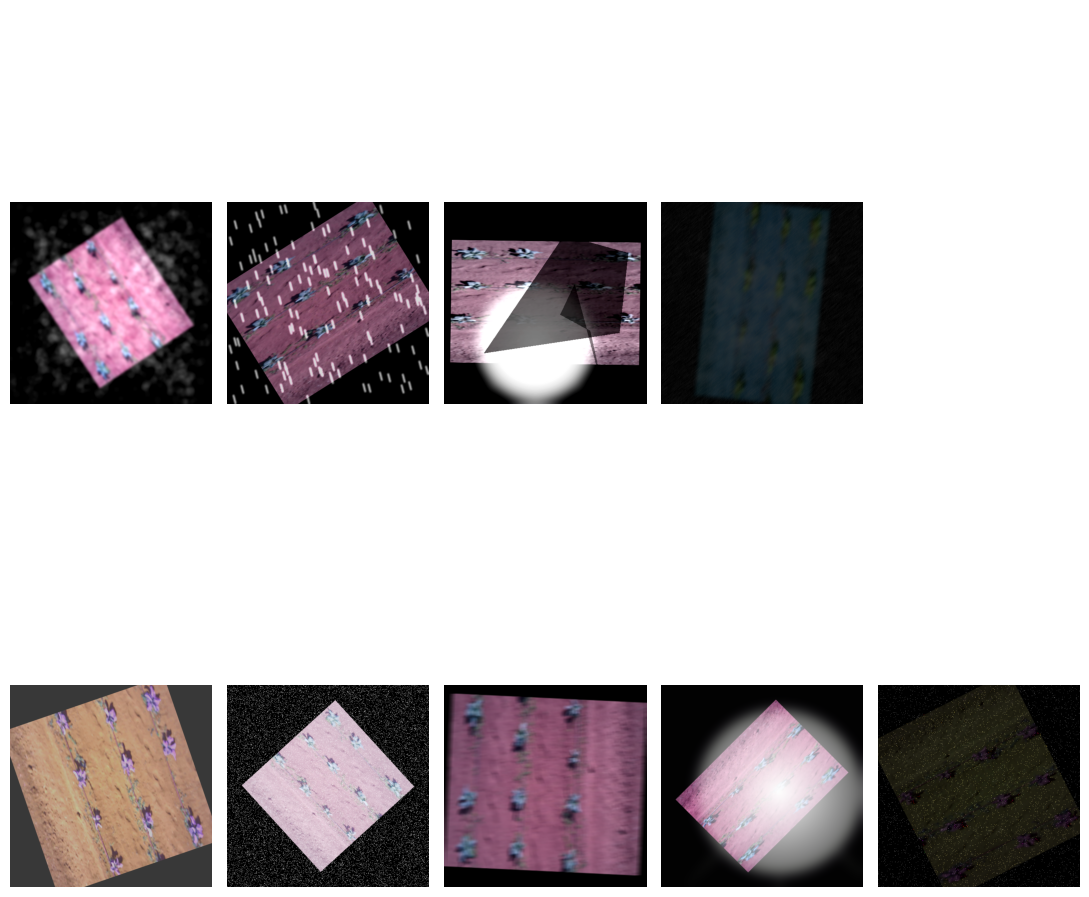

In [39]:
fig, axs = plt.subplots(2, 5, figsize=(11, 11))

img = agiadapt_img_1[0][0].copy()

axs[0, 0].imshow(img)
axs[0, 0].axis('off')

axs[0, 1].imshow(agiadapt_img_2[0][0])
axs[0, 1].axis('off')
        
axs[0, 2].imshow(agiadapt_img_3[0][0])
axs[0, 2].axis('off')

axs[0, 3].imshow(agiadapt_img_4[0][0])
axs[0, 3].axis('off')

# axs[0, 4].imshow(agiadapt_img_5[0][0])
axs[0, 4].axis('off')
        
axs[1, 0].imshow(agiadapt_img_6[0][0])
axs[1, 0].axis('off')

axs[1, 1].imshow(agiadapt_img_7[0][0])
axs[1, 1].axis('off')

axs[1, 2].imshow(agiadapt_img_8[0][0])
axs[1, 2].axis('off')
        
axs[1, 3].imshow(agiadapt_img_9[0][0])
axs[1, 3].axis('off')

axs[1, 4].imshow(agiadapt_img_10[0][0])
axs[1, 4].axis('off')


plt.tight_layout()
plt.show()

Train and test split

In [40]:
from sklearn.model_selection import train_test_split as tts

In [41]:
for i in range(len(resized_to_labels)): 
    array = []
    mask = resized_to_labels[i].copy()
    
    contours, _ = cv2.findContours(
        (mask == 255).astype(np.uint8),
          cv2.RETR_EXTERNAL,
          cv2.CHAIN_APPROX_SIMPLE)
        
    for cnt in contours:
        epsilon = 0.001 * cv2.arcLength(cnt, True)
        polygon = cv2.approxPolyDP(cnt, epsilon, True)
        # polygons.append(polygon)
            
        flattened_polygon = polygon.reshape(-1, 2).flatten().tolist()
        array.append(flattened_polygon)
    
    resized_to_labels[i] = array

clean-0, fog-1, rain-2, SunFlare-3, DustStorm-4, cloudy-5, dirty_lens-6, motion_blur-7, overexposed_sensor-8, low_light_noise-9


In [42]:
# Combination of arrays into one
yolo_or_polygon_train = [] # "yolo" or "polygon"
yolo_or_polygon_test = [] # "yolo" or "polygon"
images_train = []
images_test = []
labels_train = []
labels_test = []
types = []

# Agriadapt
x_train, x_test, y_train, y_test = tts(resized_ag_images, resized_ag_labels, test_size = 0.3, random_state = 45, shuffle = True)
for j in x_train:
    images_train.append(j)
    yolo_or_polygon_train.append("yolo")

for j in y_train:
    labels_train.append(j)

for j in x_test:
    images_test.append(j)
    yolo_or_polygon_test.append("yolo")
    types.append(0)

for j in y_test:
    labels_test.append(j)

# Chicory
x_train, x_test, y_train, y_test = tts(resized_ch_images, resized_ch_labels, test_size = 0.3, random_state = 45, shuffle = True)
for j in x_train:
    images_train.append(j)
    yolo_or_polygon_train.append("yolo")

for j in y_train:
    labels_train.append(j)

for j in x_test:
    images_test.append(j)
    yolo_or_polygon_test.append("yolo")
    types.append(0)

for j in y_test:
    labels_test.append(j)

# Tobacco
x_train, x_test, y_train, y_test = tts(resized_to_images, resized_to_labels, test_size = 0.3, random_state = 45, shuffle = True)
for j in x_train:
    images_train.append(j)
    yolo_or_polygon_train.append("polygon")

for j in y_train:
    labels_train.append(j)

for j in x_test:
    images_test.append(j)
    yolo_or_polygon_test.append("polygon")
    types.append(0)

for j in y_test:
    labels_test.append(j)

In [43]:
len(images_train), len(labels_train), len(images_test), len(labels_test)

(420, 420, 180, 180)

In [44]:
arr1 = [agiadapt_img_1, agiadapt_img_2, agiadapt_img_3, agiadapt_img_4, 
        agiadapt_img_6, agiadapt_img_7, agiadapt_img_8, agiadapt_img_9, agiadapt_img_10]

arr2 = [chicory_img_1, chicory_img_2, chicory_img_3, chicory_img_4, 
        chicory_img_6, chicory_img_7, chicory_img_8, chicory_img_9, chicory_img_10]

arr3 = [tobacco_img_1, tobacco_img_2, tobacco_img_3, tobacco_img_4, 
        tobacco_img_6, tobacco_img_7, tobacco_img_8, tobacco_img_9, tobacco_img_10]

arr1_lbl = [agiadapt_lbl_1, agiadapt_lbl_2, agiadapt_lbl_3, agiadapt_lbl_4, 
            agiadapt_lbl_6, agiadapt_lbl_7, agiadapt_lbl_8, agiadapt_lbl_9, agiadapt_lbl_10]

arr2_lbl = [chicory_lbl_1, chicory_lbl_2, chicory_lbl_3, chicory_lbl_4, 
            chicory_lbl_6, chicory_lbl_7, chicory_lbl_8, chicory_lbl_9, chicory_lbl_10]

arr3_lbl = [tobacco_lbl_1, tobacco_lbl_2, tobacco_lbl_3, tobacco_lbl_4, 
            tobacco_lbl_6, tobacco_lbl_7, tobacco_lbl_8, tobacco_lbl_9, tobacco_lbl_10]

In [45]:
len(agiadapt_img_1), len(chicory_img_1), len(tobacco_img_1)

(50, 41, 60)

In [46]:
# tobacco dataset
for i in range(len(arr3_lbl)): 
    array = []
    for j in range(len(arr3_lbl[i])):
        loc = []
        mask = arr3_lbl[i][j][0].copy()
    
        contours, _ = cv2.findContours(
            (mask == 255).astype(np.uint8),
             cv2.RETR_EXTERNAL,
             cv2.CHAIN_APPROX_SIMPLE)
        
        polygons = []
        
        for cnt in contours:
            epsilon = 0.001 * cv2.arcLength(cnt, True)
            polygon = cv2.approxPolyDP(cnt, epsilon, True)
            # polygons.append(polygon)
            
            flattened_polygon = polygon.reshape(-1, 2).flatten().tolist()
            polygons.append(flattened_polygon)
        
        
        loc.append(polygons)

        # - - -
        # mask = arr3_lbl[i][j][1].copy()
    
        # contours, _ = cv2.findContours(
        #     (mask == 255).astype(np.uint8),
        #      cv2.RETR_EXTERNAL,
        #      cv2.CHAIN_APPROX_SIMPLE)
        
        # polygons = []
        
        # for cnt in contours:
        #     epsilon = 0.001 * cv2.arcLength(cnt, True)
        #     polygon = cv2.approxPolyDP(cnt, epsilon, True)
        #     # polygons.append(polygon)
            
        #     flattened_polygon = polygon.reshape(-1, 2).flatten().tolist()
        #     polygons.append(flattened_polygon)
        
        # loc.append(polygons)

        array.append(loc)
    
    arr3_lbl[i] = array

In [47]:
for i in range(0, 9):
    # Agriadapt
    x_train, x_test, y_train, y_test = tts(arr1[i], arr1_lbl[i], test_size = 0.3, random_state = 45, shuffle = True)
    for j in x_train:
        for l in j:
            images_train.append(l)
            yolo_or_polygon_train.append("yolo")
    
    for j in y_train:
        for l in j:
            labels_train.append(l)
    
    for j in x_test:
        for l in j:
            images_test.append(l)
            yolo_or_polygon_test.append("yolo")
            types.append(i+1)
    
    for j in y_test:
        for l in j:
            labels_test.append(l)
    
    # Chicory
    x_train, x_test, y_train, y_test = tts(arr2[i], arr2_lbl[i], test_size = 0.3, random_state = 45, shuffle = True)
    for j in x_train:
        for l in j:
            images_train.append(l)
            yolo_or_polygon_train.append("yolo")
    
    for j in y_train:
        for l in j:
            labels_train.append(l)
    
    for j in x_test:
        for l in j:
            images_test.append(l)
            yolo_or_polygon_test.append("yolo")
            types.append(i+1)
    
    for j in y_test:
        for l in j:
            labels_test.append(l)
    
    # Tobacco
    x_train, x_test, y_train, y_test = tts(arr3[i], arr3_lbl[i], test_size = 0.3, random_state = 45, shuffle = True)
    for j in x_train:
        for l in j:
            images_train.append(l)
            yolo_or_polygon_train.append("polygon")
    
    for j in y_train:
        for l in j:
            labels_train.append(l)
    
    for j in x_test:
        for l in j:
            images_test.append(l)
            yolo_or_polygon_test.append("polygon")
            types.append(i+1)
    
    for j in y_test:
        for l in j:
            labels_test.append(l)
    

In [48]:
len(images_train), len(labels_train), len(images_test), len(labels_test)

(1365, 1365, 594, 594)

In [49]:
len(yolo_or_polygon_train), len(yolo_or_polygon_test)

(1365, 594)

Masks (1 = weed, 0 = non-weed)

In [50]:
ag_mask_train = [np.zeros((512, 512), dtype=np.uint8) for i in range(len(labels_train))]
ag_mask_test = [np.zeros((512, 512), dtype=np.uint8) for i in range(len(labels_test))]
for i in range(len(ag_mask_train)):
    if yolo_or_polygon_train[i] == "yolo":
        for j in labels_train[i]:
            x = j[0] - j[2]/2
            y = j[1] - j[3]/2
            x1 = j[0] + j[2]/2
            y1 = j[1] + j[3]/2
            x, y, x1, y1 = int(x*512), int(y*512), int(x1*512), int(y1*512)
            cv2.rectangle(ag_mask_train[i], (x, y1), (x1, y), color=1, thickness=cv2.FILLED)

    else:
        for j in labels_train[i]:
            polygon = np.array(j).reshape(-1, 2)
            cv2.fillPoly(ag_mask_train[i], [polygon], color=1)

for i in range(len(ag_mask_test)):
    if yolo_or_polygon_test[i] == "yolo":
        for j in labels_test[i]:
            x = j[0] - j[2]/2
            y = j[1] - j[3]/2
            x1 = j[0] + j[2]/2
            y1 = j[1] + j[3]/2
            x, y, x1, y1 = int(x*512), int(y*512), int(x1*512), int(y1*512)
            cv2.rectangle(ag_mask_test[i], (x, y1), (x1, y), color=1, thickness=cv2.FILLED)

    else:
        for j in labels_test[i]:
            polygon = np.array(j).reshape(-1, 2)
            cv2.fillPoly(ag_mask_test[i], [polygon], color=1)

In [51]:
# images_train = np.load('augmented_images.npy')
# ag_mask_train = np.load('augmented_images.npy')
# images_test = np.load('augmented_images.npy')
# ag_mask_test = np.load('augmented_images.npy')
# types_simulation = np.load('types.npy')
# np.savez_compressed('images_train.npy', np.array(images_train))
# np.savez_compressed('ag_mask_train.npy', np.array(ag_mask_train))
# np.savez_compressed('images_test.npy', np.array(images_test))
# np.savez_compressed('ag_mask_test.npy', np.array(ag_mask_test))
# np.savez_compressed('types_simulation.npy', np.array(types))

Model

In [52]:
# Decoder DeepLabV3+ to predict pixels as weed/non-weed
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return ops.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


In [53]:
import tensorflow as tf
import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers, models, applications
from keras.preprocessing import image
from keras import ops
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = keras.applications.EfficientNetV2S(weights='imagenet', include_top=False, input_shape = (512, 512, 3))
model.summary()

# Print layer names
# for idx, layer in enumerate(model.layers):
#     print(f"{idx}: {layer.name}")

Model: "efficientnetv2-s"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 512, 512, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 512, 512, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 256, 256, 24)      │             648 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 256, 256, 24)      │              96 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 256, 256, 24)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 256, 256, 24)      │           5,184 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 256, 256, 24)      │              96 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_activation    │ (None, 256, 256, 24)      │               0 │ block1a_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_add (Add)             │ (None, 256, 256, 24)      │               0 │ block1a_project_activatio… │
│                               │                           │                 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_conv (Conv2D) │ (None, 256, 256, 24)      │           5,184 │ block1a_add[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_bn            │ (None, 256, 256, 24)      │              96 │ block1b_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_activation    │ (None, 256, 256, 24)      │               0 │ block1b_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_drop (Dropout)        │ (None, 256, 256, 24)      │               0 │ block1b_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_add (Add)             │ (None, 256, 256, 24)      │               0 │ block1b_drop[0][0],        │
│                               │                           │                 │ block1a_add[0][0]          │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 20,331,360 (77.56 MB)

 Trainable params: 20,177,488 (76.97 MB)

 Non-trainable params: 153,872 (601.06 KB)

In [54]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    
    EfficientNetV2S = keras.applications.EfficientNetV2S(
        weights="imagenet", include_top=False, input_tensor=model_input)
    
    x = EfficientNetV2S.get_layer("block6m_activation").output
    x = DilatedSpatialPyramidPooling(x)
    # print(x.shape)

    input_a = layers.UpSampling2D(
        size=(image_size // 8 // x.shape[1], image_size // 8 // x.shape[2]),
        interpolation="bilinear",)(x)
    input_b = EfficientNetV2S.get_layer("block3d_expand_activation").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)
    print(x.shape)
    print(input_a.shape)
    print(input_b.shape)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same", activation='sigmoid')(x)
    print(model_output.shape)
    
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=512, num_classes=1)
model.summary()

(None, 16, 16, 256)
(None, 64, 64, 256)
(None, 64, 64, 48)
(None, 512, 512, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 512, 512, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 512, 512, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 256, 256, 24)      │             648 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 256, 256, 24)      │              96 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 256, 256, 24)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 256, 256, 24)      │           5,184 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 256, 256, 24)      │              96 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_activation    │ (None, 256, 256, 24)      │               0 │ block1a_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_add (Add)             │ (None, 256, 256, 24)      │               0 │ block1a_project_activatio… │
│                               │                           │                 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_conv (Conv2D) │ (None, 256, 256, 24)      │           5,184 │ block1a_add[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_bn            │ (None, 256, 256, 24)      │              96 │ block1b_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_activation    │ (None, 256, 256, 24)      │               0 │ block1b_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_drop (Dropout)        │ (None, 256, 256, 24)      │               0 │ block1b_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_add (Add)             │ (None, 256, 256, 24)      │               0 │ block1b_drop[0][0],        │
│                               │                           │                 │ block1a_add[0][0]          │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 30,424,929 (116.06 MB)

 Trainable params: 30,283,249 (115.52 MB)

 Non-trainable params: 141,680 (553.44 KB)

In [55]:
# from keras.callbacks import Callback
# class custom_callback(Callback):
#     def on_batch_end(self, epoch, logs=None):
#       # Get predictions on validation data
#         predictions = self.model.predict(c)
#         predictions = tf.cast(predictions > 0.5, tf.uint8 )
#         #print(y_pred)
#         predictions = tf.squeeze(predictions)
#         print(predictions[-1])
#         print(predictions[-1].shape)
        


Loss

In [56]:
def my_loss_fn(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    y_pred = tf.squeeze(y_pred)
    # y_pred = tf.cast(y_pred > 0.5, tf.float32)
    # smooth = 100
    intersection = tf.reduce_sum(y_true * y_pred)
    sum_ = tf.reduce_sum(y_true + y_pred)
    jac = (intersection) / (sum_ - intersection + 1e-7)
    return (1 - jac) 

Models

In [57]:
class Accuracy(keras.metrics.Metric):
    def __init__(self, name='accuracy', **kwargs):
        super().__init__(name=name, **kwargs)
        self.correct = self.add_weight(name='correct', initializer='zeros')
        self.total = self.add_weight(name='total', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_binary = tf.cast(y_pred > 0.5, tf.uint8)
        y_pred_binary = tf.squeeze(y_pred_binary)

        correct = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred_binary), tf.int32))
        total = tf.cast(tf.size(y_true), tf.int32)

        self.correct.assign_add(correct)
        self.total.assign_add(total)

    def result(self):
        return self.correct / self.total  

    def reset_states(self):
        self.correct.assign(0)
        self.total.assign(0)

In [58]:
class IoU(keras.metrics.Metric):
    def __init__(self, name='IoU', **kwargs):
        super().__init__(name=name, **kwargs)
        self.tp = self.add_weight(name='tp', initializer='zeros') # true positives
        self.fp = self.add_weight(name='fp', initializer='zeros') # false positives
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_binary = tf.cast(y_pred > 0.5, tf.uint8)
        y_pred_binary = tf.squeeze(y_pred_binary)

        tp = tf.reduce_sum(y_true * y_pred_binary) 
        fp = tf.reduce_sum((1 - y_true) * y_pred_binary)  
        fn = tf.reduce_sum(y_true * (1 - y_pred_binary))  

        # Update the counts
        self.tp.assign_add(tp)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        # Calculate IoU
        iou_value = self.tp / (self.tp + self.fp + self.fn + tf.keras.backend.epsilon())
        return iou_value

    def reset_states(self):
        self.tp.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)


In [59]:
class F1(keras.metrics.Metric):
    def __init__(self, name='F1', **kwargs):
        super().__init__(name=name, **kwargs)
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_binary = tf.cast(y_pred > 0.5, tf.uint8)
        y_pred_binary = tf.squeeze(y_pred_binary)

        tp = tf.reduce_sum(y_true * y_pred_binary)  
        fp = tf.reduce_sum((1 - y_true) * y_pred_binary)  
        fn = tf.reduce_sum(y_true * (1 - y_pred_binary))  

        # Update the counts
        self.tp.assign_add(tp)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        precision = self.tp / (self.tp + self.fp + tf.keras.backend.epsilon())
        recall = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())

        f1_value = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1_value

    def reset_states(self):
        self.tp.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)


In [60]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=my_loss_fn, metrics=[Accuracy(), IoU(), F1()])

In [61]:
# for x, y in train_dataset.take(1):
#     print(x.shape, y.shape)  # Should show (64, 512, 512, 3) and (64, 512, 512, 1)
#     print(x.dtype, y.dtype)  

In [62]:
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=my_loss_fn, metrics=[Accuracy(), IoU(), F1()])

In [63]:
# model.fit(train_dataset, epochs=10)

In [64]:
# model.fit(np.array(images_train),np.array(ag_mask_train), batch_size = 65, epochs = 20, validation_data=(np.array(images_test), np.array(ag_mask_test))) #callbacks=[custom_callback()]

In [65]:
model.load_weights('model_weights.weights.h5')

C:\Users\Kirill\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 890 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Evaluation

In [66]:
# model.evaluate(c, d)

In [67]:
val_dataset = tf.data.Dataset.from_tensor_slices((images_test, ag_mask_test))
val_dataset = val_dataset.batch(3).prefetch(2)  

model.evaluate(val_dataset)

198/198 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - F1: 0.5057 - IoU: 0.3388 - accuracy: 0.9618 - loss: 0.4997


[0.5518432259559631, 0.9584482908248901, 0.3309796452522278, 0.497347354888916]

In [68]:
for i in range(0,10):
    img = []
    lbl = []
    for j in range(len(images_test)):
        if types[j] == i:
            img.append(images_test[j])
            lbl.append(ag_mask_test[j])

    val_dataset = tf.data.Dataset.from_tensor_slices((img, lbl))
    val_dataset = val_dataset.batch(3).prefetch(2)  
    model.evaluate(val_dataset)

60/60 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - F1: 0.5252 - IoU: 0.3570 - accuracy: 0.9628 - loss: 0.4890
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - F1: 0.5056 - IoU: 0.3398 - accuracy: 0.9462 - loss: 0.5720
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - F1: 0.4833 - IoU: 0.3193 - accuracy: 0.9444 - loss: 0.5107
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - F1: 0.4149 - IoU: 0.2679 - accuracy: 0.9465 - loss: 0.6107
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - F1: 0.4351 - IoU: 0.2816 - accuracy: 0.9200 - loss: 0.7887
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - F1: 0.5745 - IoU: 0.4040 - accuracy: 0.9424 - loss: 0.6264
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - F1: 0.4643 - IoU: 0.3035 - accuracy: 0.9513 - loss: 0.5492
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - F1: 0.5602 - IoU: 0.3925 - accuracy: 0.9453 - loss: 0.5742
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - F1: 0.4411 - IoU: 0.2855 - accuracy: 0.9411 - loss: 0.6501
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - F1: 0.4968 - IoU: 0.3373 - accuracy: 0.9474 - loss: 0.6358


In [69]:
for i in range(0,10):
    img = []
    lbl = []
    for j in range(len(images_test)):
        if types[j] == i:
            img.append(images_test[j])
            lbl.append(ag_mask_test[j])
            
    print(len(img))

180
46
46
46
46
46
46
46
46
46
